# <center> Bike Share Toronto: The Newest Way of City Traveling  </center>
### <center> Due date: February 3, 11:59pm </center>
<center>  Yun Shen </center>


***

<img src='toronto bike share.jpg' >

## Introduction

Over the past few years, sharing economy has become one of the fastest growing business trends in history. Not exactly  the same to the shared bikes in China, Toronto Bike Share still offers its users a platform to enjoy convinient ways to transportation to every corner of the city and facilities the process of borrowing and returning the bikes as of its expansion these years due to the increase in TTC fares and traffic. It's interesting to discover how Bike Share Toronto develops and how the users change their transportation preferences during these years. Specificly, this report will focus on:
1. Define trip length in two ways.
2. Find out a relationship between two definitions of trip length.
3. Find out if casual users take shorter trips compared to members.
4. Find out if season or weather affect trip length? 

## Data Overview
Bike Share collects data using systems provided by third-party organizations, which is available at [https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/](https://open.toronto.ca/dataset/bike-share-toronto-ridership-data/). Therefore, only 2016 Q3, 2016 Q4, and 2017 Toronto Bikeshare ridership data are available to download and use as CSV files. By previewing the 2016 Q3 data, here are the description of each column of data:
* **trip_id:** unique identifier for each trip
* **trip_start_time:** time when the trip started
* **trip_stop_time:** time when the trip ended
* **trip_duration_seconds:** duration of the trip measured in seconds
* **from_station_id:** station ID where the trip started
* **from_station_name:** name of the station where the trip started
* **to_station_id:** station ID where the trip ended
* **to_station_name:** name of the station where the trip ended
* **user_type:** identify if the user has a membership or purchased a pass

Station information, including real time data, is available at [https://open.toronto.ca/dataset/bike-share-toronto/](https://open.toronto.ca/dataset/bike-share-toronto/). The station information will be used to calculate the distance of the trips

Historical weather data is available from a Government of Canada [https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=1#](https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2017&Month=1#).

## Data Cleaning

In [1]:
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from fuzzywuzzy import fuzz
from geopy import distance
from geopy.distance import geodesic
import numpy as np
import json
import os


First, I imported the required libraries and loaded the station data from the Bike Share API endpoint. Here the the data overview:

In [2]:
import requests
import json

r = requests.get('https://tor.publicbikesystem.net/ube/gbfs/v1/en/station_information')

bikeshare_stations = pd.DataFrame(json.loads(r.content)['data']['stations'])[['station_id', 'name', 'lat', 'lon']].astype({
    'station_id': 'float64',
})

bikeshare_stations.to_csv('bikeshare_stations.csv', index=False)


In [3]:
bikeshare_stations

,station_id,name,lat,lon
0,7000.0,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001.0,Lower Jarvis St / The Esplanade,43.647992,-79.370907
2,7002.0,St. George St / Bloor St W,43.667333,-79.399429
3,7003.0,Madison Ave / Bloor St W,43.667158,-79.402761
4,7004.0,University Ave / Elm St,43.656518,-79.389099
...,...,...,...,...
458,7505.0,Ontario St / Adelaide St E -SMART,43.652458,-79.366433
459,7506.0,Berkeley St / Adelaide St E - SMART,43.653359,-79.365023
460,7508.0,Berkeley St / Dundas St E - SMART,43.658816,-79.367318
461,7509.0,Ontario St / King St E,43.651814,-79.366194


I then loaded the bike share ridership data from the downloaded csv files. I indentified the date structure of each file as a dict and convert the date into a Datetime object.  

In [5]:
# Identify the date structure used by each of the files as a dict:
#      * Key: data file name
#      * Value: [datetime format, hour difference bewteen timezone used and Eastern timezone]
date_formats = {
    'bikeshare-ridership-2016-q3.csv': ['%m/%d/%Y %H:%M:%S', 0],
    'Bikeshare Ridership (2017 Q1).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q2).csv': ['%d/%m/%Y %H:%M', -4],
    'Bikeshare Ridership (2017 Q3).csv': ['%m/%d/%Y %H:%M', 0],
    'Bikeshare Ridership (2017 Q4).csv': ['%m/%d/%y %H:%M:%S', 0],
}
df = pd.DataFrame() # Initiate an empty DataFrame
for fn, fmt in date_formats.items():
    tmp = pd.read_csv(fn)
    # Read the datetime in the specified format
    tmp['trip_start_time'] = pd.to_datetime(tmp['trip_start_time'], format=fmt[0], errors='coerce')
    tmp['trip_stop_time'] = pd.to_datetime(tmp['trip_stop_time'], format=fmt[0],  errors='coerce')

    # Convert the input time to the Easter timezone
    
    tmp['trip_start_time'] = tmp['trip_start_time'] + timedelta(hours=fmt[1])
    tmp['trip_stop_time'] = tmp['trip_stop_time'] + timedelta(hours=fmt[1])
    df = pd.concat([df, tmp], sort=False).reset_index(drop=True)

However, I noticed that the bike share ridership information in 2016 Q4 has multiple date formats. Some include the seconds, and some do not include the seconds. In addition, there are a few entries having different formats of start time and stop time. Thus, I decided to standardize the date format of 2016 Q4 data separately from the previous ones. I made three copys of the 2016 Q4 data, and convert the date into Datetime objects by using three different formats. Then I dropped all the NaN entries and concatenate all three dataframes into a new one, adding it to the mega dataframe.

In [6]:
q4_2016 = pd.read_csv("bikeshare-ridership-2016-q4.csv")
copy_1 = q4_2016.copy()
copy_1['trip_start_time'] = pd.to_datetime(copy_1['trip_start_time'], format='%d/%m/%Y %H:%M', errors='coerce')
copy_1['trip_stop_time'] = pd.to_datetime(copy_1['trip_stop_time'], format='%d/%m/%Y %H:%M',  errors='coerce')
copy_1 = copy_1.dropna()
copy_2 = q4_2016.copy()
copy_2['trip_start_time'] = pd.to_datetime(copy_2['trip_start_time'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
copy_2['trip_stop_time'] = pd.to_datetime(copy_2['trip_stop_time'], format='%d/%m/%Y %H:%M:%S',  errors='coerce')
copy_2 = copy_2.dropna()
copy_3 = q4_2016.copy()
copy_3['trip_start_time'] = pd.to_datetime(copy_3['trip_start_time'], format='%d/%m/%Y %H:%M', errors='coerce')
copy_3['trip_stop_time'] = pd.to_datetime(copy_3['trip_stop_time'], format='%d/%m/%Y %H:%M:%S',  errors='coerce')
copy_3 = copy_3.dropna()

cleaned = pd.concat([copy_1, copy_2, copy_3])
cleaned.sort_values(by=['trip_id'])


,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type
0,462305,2016-10-01 00:00:00,2016-10-01 00:07:00,394,Queens Quay W / Dan Leckie Way,Fort York Blvd / Garrison Rd,Casual
1,462306,2016-10-01 00:00:00,2016-10-01 00:09:00,533,Sherbourne St / Wellesley St,Edward St / Yonge St,Member
2,462307,2016-10-01 00:00:00,2016-10-01 00:07:00,383,Queens Quay W / Dan Leckie Way,Fort York Blvd / Garrison Rd,Casual
3,462308,2016-10-01 00:01:00,2016-10-01 00:27:00,1557,Cherry St / Distillery Ln,Fort York Blvd / Capreol Crt,Casual
4,462309,2016-10-01 00:01:00,2016-10-01 00:27:00,1547,Cherry St / Distillery Ln,Fort York Blvd / Capreol Crt,Casual
...,...,...,...,...,...,...,...
217564,712377,2016-12-31 23:26:00,2016-12-31 23:39:00,824,Union Station,Gould St / Mutual St,Member
217565,712378,2016-12-31 23:26:00,2016-12-31 23:34:00,478,Bay St / College St (East Side),Beverly St / Dundas St W,Member
217566,712379,2016-12-31 23:33:00,2016-12-31 23:38:00,271,Temperance St / Yonge St,Victoria St / Gould St (Ryerson University),Member
217567,712380,2016-12-31 23:37:00,2016-12-31 23:58:00,1253,Christie St / Benson Ave (Wychwood Barns),Wellesley St E / Yonge St Green P,Member


In [7]:
df.append(cleaned, sort=False)
df.sort_values(by=['trip_id'])

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,from_station_name,to_station_name,user_type,from_station_id,to_station_id
35445,24008,2016-07-01 00:00:00,2016-07-01 00:08:00,505,College St W / Huron St,Queens Park / Bloor St W,Member,NaN,NaN
110732,24009,2016-07-01 00:00:00,2016-07-01 00:10:00,603,Wellington St W / Bay St,King St W / Spadina Ave,Member,NaN,NaN
172573,24010,2016-07-01 00:00:00,2016-07-01 00:42:00,2487,Bay St / Queens Quay W (Ferry Terminal),York St / Queens Quay W,Casual,NaN,NaN
169223,24011,2016-07-01 00:01:00,2016-07-01 00:07:00,399,Trinity St /Front St E,Princess St / Adelaide St,Member,NaN,NaN
128416,24012,2016-07-01 00:01:00,2016-07-01 00:12:00,662,Simcoe St / Queen St W,Queen St W / Spadina Ave,Member,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1860326,2383642,2017-12-31 23:46:27,2017-12-31 23:46:53,26,Bloor St / Brunswick Ave,Bloor St / Brunswick Ave,Casual,NaN,NaN
1860327,2383643,2017-12-31 23:47:13,2018-01-01 00:11:40,1467,Bloor St / Brunswick Ave,HTO Park (Queens Quay W),Casual,NaN,NaN
1860328,2383644,2017-12-31 23:47:40,2017-12-31 23:57:49,609,Kendal Ave / Spadina Rd,Augusta Ave / Denison Sq,Member,NaN,NaN
1860329,2383645,2017-12-31 23:49:08,2017-12-31 23:49:34,26,Phoebe St / Spadina Ave,Phoebe St / Spadina Ave,Member,NaN,NaN


Next, I needed to resolve the issues with the station IDs and names. I extracted the unique combinations of station ID and station name. The stations with IDs can be updated from the API easily, but the stations without IDs need more manipulations. Here, I refered to Yizhao's solution [https://towardsdatascience.com/exploring-toronto-bike-share-ridership-using-python-3dc87d35cb62](website) to clean the data.


In [8]:
stations_start = df[['from_station_id', 'from_station_name']]
stations_end = df[['to_station_id', 'to_station_name']]
stations_start.columns = stations_end.columns = ['station_id', 'name']

# Extracts the unique station ID and name combination from the from_station and to_station columns
stations = pd.concat([stations_start, stations_end]).dropna(how='all').drop_duplicates().reset_index(drop=True)

In [9]:
pd.set_option('display.max_rows', None)
print(stations)

     station_id                                           name
0           NaN                 Dundas St E / Regent Park Blvd
1           NaN           Riverdale Park North (Broadview Ave)
2           NaN                                  Union Station
3           NaN                     Front St W / Blue Jays Way
4           NaN                       Queens Park / Bloor St W
5           NaN                    Simcoe St / Wellington St W
6           NaN                        Danforth Ave / Lamb Ave
7           NaN                        King St W / Spadina Ave
8           NaN                    Dundas St E / Broadview Ave
9           NaN                               51 Parliament St
10          NaN                       Queen St W / Portland St
11          NaN                     Central Tech  (Harbord St)
12          NaN                     Parliament St / Gerrard St
13          NaN               Wellesley St / Queen's Park Cres
14          NaN     Sherbourne St / Carlton St (Allan G

In [10]:
# Separate the stations without station IDs
no_ids = stations[stations['station_id'].isnull()]
for idx, miss in no_ids.iterrows():
    max_score = 0
    
    # Compare the similarity of the station without ID to each station in the API data
    for i, exist in bikeshare_stations[['station_id', 'name']].iterrows():
        score = fuzz.ratio(miss['name'], exist['name'])
        
        if score > 80 and score > max_score:
            max_score = score
            no_ids.at[idx, 'station_id'] = exist['station_id']
    
    # Warn if the station was not able to be matched
    if max_score <= 80:
        print('WARN: {0} station could not be matched to an existing station'.format(miss['name']))
        
# Remove all stations that were not matched
no_ids = no_ids.dropna()


WARN: Victoria St / Gould St (Ryerson University) station could not be matched to an existing station
WARN: Bloor St / Brunswick Ave station could not be matched to an existing station
WARN: Bay St / Bloor St W station could not be matched to an existing station
WARN: Bremner Blvd / Spadina Ave station could not be matched to an existing station
WARN: Dockside Dr / Queens Quay E (Sugar Beach) station could not be matched to an existing station
WARN: Temperance St / Yonge St station could not be matched to an existing station
WARN: Ontario Place Blvd / Remembrance Dr station could not be matched to an existing station
WARN: Landsdowne Subway Green P station could not be matched to an existing station
WARN: Bathurst St / Queens Quay W station could not be matched to an existing station
WARN: Bloor GO / UP Station/ Rail Path station could not be matched to an existing station
WARN: Stephenson Ave / Main St station could not be matched to an existing station
WARN: Woodbine Subway Green P (

I then update the correct station information in the mega dataframe.

In [11]:
stations = pd.concat([stations[~stations['station_id'].isnull()], no_ids])\
             .merge(bikeshare_stations[['station_id', 'lat', 'lon']], how='inner', on='station_id')\
             .drop_duplicates()

In [12]:
df = df.merge(stations, how='inner', left_on='from_station_name', right_on='name') \
       .merge(stations, how='inner', left_on='to_station_name', right_on='name', suffixes=['_from', '_to']) \
       .drop_duplicates()
df = df[[x for x in df.columns if not x.endswith('_station_id') and not x.endswith('_station_name')]]


In [13]:
df.head()

,trip_id,trip_start_time,trip_stop_time,trip_duration_seconds,user_type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to
0,53279,2016-07-09 01:03:00,2016-07-09 01:15:00,714,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
1,325766,2016-09-03 22:37:00,2016-09-03 22:48:00,685,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
2,178309,2016-08-05 16:21:00,2016-08-05 16:33:00,718,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
3,425555,2016-09-23 10:15:00,2016-09-23 10:28:00,792,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667
4,1043167,2017-05-23 21:16:00,2017-05-23 21:30:00,852,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667


I renamed the columns so that they are easier to read and refer in the future. I also created three
new columns which are Year, Month, Day to indicate the date of the trip so that the weather data
can be easily identified to the correct trip.

In [14]:
df = df.rename(columns={"trip_id": "ID", "trip_start_time": "Start Time", "trip_duration_seconds": "Duration Length", \
                  "user_type": "User Type"})
#df['Quarter'] = df['trip_start_time'].apply(lambda x: int((int(x.strftime('%m')) - 1) / 3) + 1)
df['Year'] = pd.DatetimeIndex(df['Start Time']).year 
df['Month'] = pd.DatetimeIndex(df['Start Time']).month 
df['Day'] = pd.DatetimeIndex(df['Start Time']).day 


In [15]:
df.head()

,ID,Start Time,trip_stop_time,Duration Length,User Type,station_id_from,name_from,lat_from,lon_from,station_id_to,name_to,lat_to,lon_to,Year,Month,Day
0,53279,2016-07-09 01:03:00,2016-07-09 01:15:00,714,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667,2016,7,9
1,325766,2016-09-03 22:37:00,2016-09-03 22:48:00,685,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667,2016,9,3
2,178309,2016-08-05 16:21:00,2016-08-05 16:33:00,718,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667,2016,8,5
3,425555,2016-09-23 10:15:00,2016-09-23 10:28:00,792,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667,2016,9,23
4,1043167,2017-05-23 21:16:00,2017-05-23 21:30:00,852,Member,7100.0,Dundas St E / Regent Park Blvd,43.660207,-79.361275,7095.0,Danforth Ave / Ellerbeck St,43.677076,-79.35667,2017,5,23


Next, I calculated the distance from the start stations to the end stations. I will talk about the use of distances later.

In [16]:
maps = df[['ID', 'station_id_from', 'lat_from', 'lon_from', 'station_id_to', 'lat_to', 'lon_to']].drop_duplicates()

maps['Distance'] = maps.apply(lambda x: distance.distance((x['lat_from'], x['lon_from']), (x['lat_to'], x['lon_to'])).km * 1000, axis=1)

# Merge the distance calculation with the main DataFrame
df = df.merge(maps[['ID', 'Distance']], how='left', on='ID')
df = df[[x for x in df.columns if not 'from' in x and not 'to' in x and x != 'ID']]

Also, I removed the outliers of distance and duration by using the 1.5*IQR standard. Since we are dealing with a large set of data, it is necessary to remove the outliers with abnormal behaviours so that when we are investigating the relationships between variables, we will not be distracted.

In [17]:
# Removing false start trips
df = df[(df['Duration Length']>=60)]

# Removing outliers
q1 = df['Duration Length'].quantile(0.25)
q3 = df['Duration Length'].quantile(0.75)

interquartile_range = q3 - q1

df = df[~((df['Duration Length'] < (q1 - 1.5 * interquartile_range)) \
         |(df['Duration Length'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)



In [18]:
# Removing outliers
q1 = df['Distance'].quantile(0.25)
q3 = df['Distance'].quantile(0.75)

interquartile_range = q3 - q1

df = df[~((df['Distance'] < (q1 - 1.5 * interquartile_range)) \
         |(df['Distance'] > (q3 + 1.5 * interquartile_range)))].reset_index(drop=True)

Here is the preview of the cleaned data. I only keep the variables that I will be using to analyze the data and I save the data as a new csv file bikeshare_ridership.csv.

In [19]:
df.head()

,Start Time,Duration Length,User Type,Year,Month,Day,Distance
0,2016-07-09 01:03:00,714,Member,2016,7,9,1910.687075
1,2016-09-03 22:37:00,685,Member,2016,9,3,1910.687075
2,2016-08-05 16:21:00,718,Member,2016,8,5,1910.687075
3,2016-09-23 10:15:00,792,Member,2016,9,23,1910.687075
4,2017-05-23 21:16:00,852,Member,2017,5,23,1910.687075


In [20]:
df.to_csv('bikeshare_ridership.csv', index=False)


Next, I need to scrape the weather data from the Government of Canada Historical Climate Data website. Since the weather data is displayed month by month on the website, I decided to write a function to scrape the data to avoid redundant codes. I passed all the weather information page to the fuunction and saved the results in separate dataframes. Then, I concatenate the data frames into a mega weather dataframe and saved it as weather.csv.

In [21]:
def generate_weather_info(url, year, month):
    weather = pd.read_html(url, header=0)[0]
    weather.drop(weather.tail(4).index,inplace=True) # drop last n rows
    weather = weather.drop(columns=['Max Temp Definition°C', 'Min Temp Definition°C', 'Heat Deg Days Definition', \
                                  'Cool Deg Days Definition', 'Dir of Max Gust Definition10\'s deg', 'Spd of Max Gust Definitionkm/h'])
    weather = weather.rename(columns={"Mean Temp Definition°C": "Mean Temp", "Total Rain Definitionmm": "Total Rain",\
                                 "Total Snow Definitioncm": "Total Snow", "Total Precip Definitionmm": "Total Precip",\
                                 "Snow on Grnd Definitioncm": "Snow on Grnd", "DAY": "Day"})
    weather['Year'] = year
    weather['Month'] = month
    return weather

In [22]:
y16_m7 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=22&Year=2016&Month=7#', \
                              2016, 7)
y16_m8 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=8', \
                              2016, 8)
y16_m9 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=9', \
                              2016, 9)
y16_m10 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=10', \
                              2016, 10)
y16_m11 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=11', \
                              2016, 11)
y16_m12 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2016&Month=12', \
                              2016, 12)
y17_m1 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=1', \
                              2017, 1)
y17_m2 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=2', \
                             2017, 2)
y17_m3 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=3', \
                             2017, 3)
y17_m4 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=4', \
                             2017, 4)
y17_m5 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=5', \
                             2017, 5)
y17_m6 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=6', \
                             2017, 6)
y17_m7 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=7', \
                             2017, 7)
y17_m8 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=8', \
                             2017, 8)
y17_m9 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=9', \
                             2017, 9)
y17_m10 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=10', \
                             2017, 10)
y17_m11 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=11', \
                             2017, 11)
y17_m12 = generate_weather_info('https://climate.weather.gc.ca/climate_data/daily_data_e.html?StationID=51459&timeframe=2&StartYear=1840&EndYear=2019&Day=1&Year=2017&Month=12', \
                             2017, 12)

In [23]:
weather = pd.concat([y16_m7, y16_m8, y16_m9, y16_m10, y16_m11, y16_m12, y17_m1, y17_m2, y17_m3, y17_m4, y17_m5, \
                    y17_m6, y17_m7, y17_m8, y17_m9, y17_m10, y17_m11, y17_m12])
weather.to_csv('weather.csv', index=False)


I merged the weather dataframe with the ridership dataframe by the year, month and day of the trip and saved the new dataframe as ridership_weather.csv.

In [24]:
weather.Day = weather.Day.astype(int)
new_df = pd.merge(df, weather, how='left', on=['Month', 'Day', 'Year'])
new_df.to_csv('ridership_weather.csv', index=False)


I noticed that some of the weather data are missing or are marked as 'Legend'. This is due to the data display on the original website. I treated all the cells with 'Legend' as NaN so that they can be easily removed when we visualize the data.

In [25]:
new_df.loc[new_df['Mean Temp'].str.contains('Legend', na=False), 'Mean Temp']= np.nan
new_df.loc[new_df['Total Rain'].str.contains('Legend', na=False), 'Total Rain'] = np.nan
new_df.loc[new_df['Total Snow'].str.contains('Legend', na=False), 'Total Snow'] = np.nan
new_df.loc[new_df['Total Precip'].str.contains('Legend', na=False), 'Total Precip'] = np.nan
new_df.loc[new_df['Snow on Grnd'].str.contains('Legend', na=False), 'Snow on Grnd'] = np.nan


In [26]:
new_df.head()

,Start Time,Duration Length,User Type,Year,Month,Day,Distance,Mean Temp,Total Rain,Total Snow,Total Precip,Snow on Grnd
0,2016-07-09 01:03:00,714,Member,2016,7,9,1910.687075,22.8,6.0,0.0,6.0,NaN
1,2016-09-03 22:37:00,685,Member,2016,9,3,1910.687075,18.2,0.0,0.0,0.0,NaN
2,2016-08-05 16:21:00,718,Member,2016,8,5,1910.687075,27.8,NaN,0.0,NaN,NaN
3,2016-09-23 10:15:00,792,Member,2016,9,23,1910.687075,16.4,1.0,0.0,1.0,NaN
4,2017-05-23 21:16:00,852,Member,2017,5,23,1910.687075,16.0,0.4,0.0,0.4,NaN


## The Relationship between Two Trip Length Definitions


First of all, trip length can be defined in two ways:

1. Duration: the difference between start time and end time of the trip in seconds
2. Distance: the distance between start station and end station of the trip in meters

The duration variable is presented in the original data set. In the data cleaning process above, I have created a new distance variable that represents the distance between the start station and end station of the trip in meters.

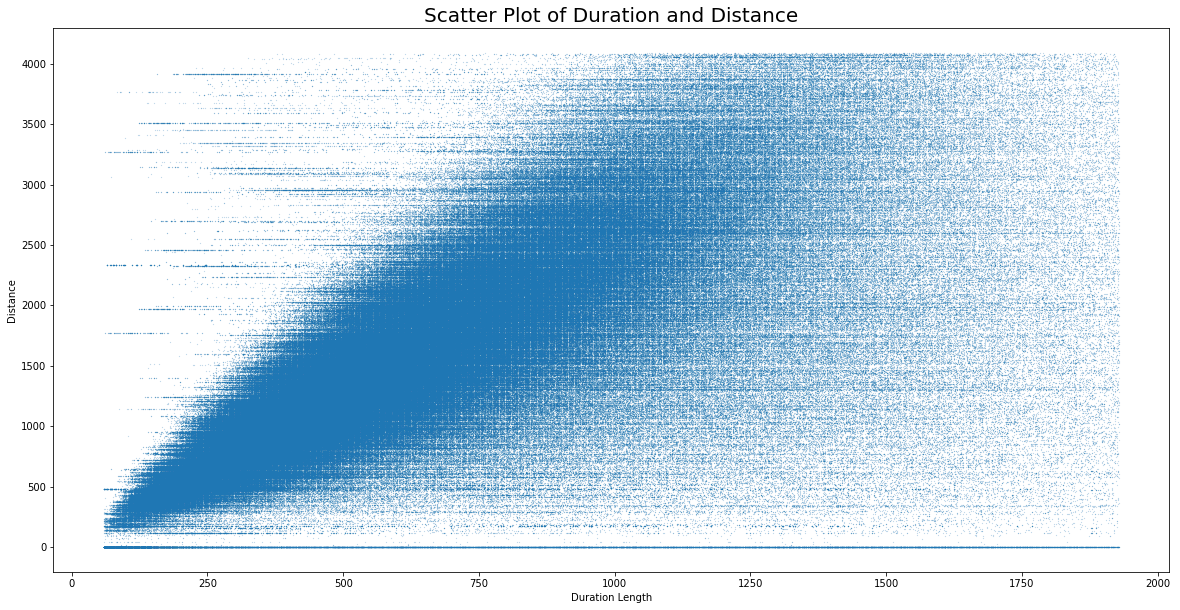

In [27]:
plt.figure(figsize=(20,10))
plt.plot('Duration Length', 'Distance', data=df, linestyle='none', marker='o', markersize=0.1)
plt.xlabel("Duration Length")
plt.ylabel("Distance")
plt.title('Scatter Plot of Duration and Distance', fontsize=20)
plt.show()

To further investigate the relationship between duration and distance, I decided to use a scatter plot. As shown in the plot, even though both duration and distance variate a lot, we can still see a dense region of points that imply a positive linear relationship between distance and duration. Another interesting point is that there is a dense line at distance 0 with a variety of durations. This indicates that trips starting and ending at the same station tend to vary in duration. This might be caused by that many people borrow bikes and return the bikes to the same station, such as the stations near the homes to finish some tasks.

## Casual Users vs. Members in Trip Length

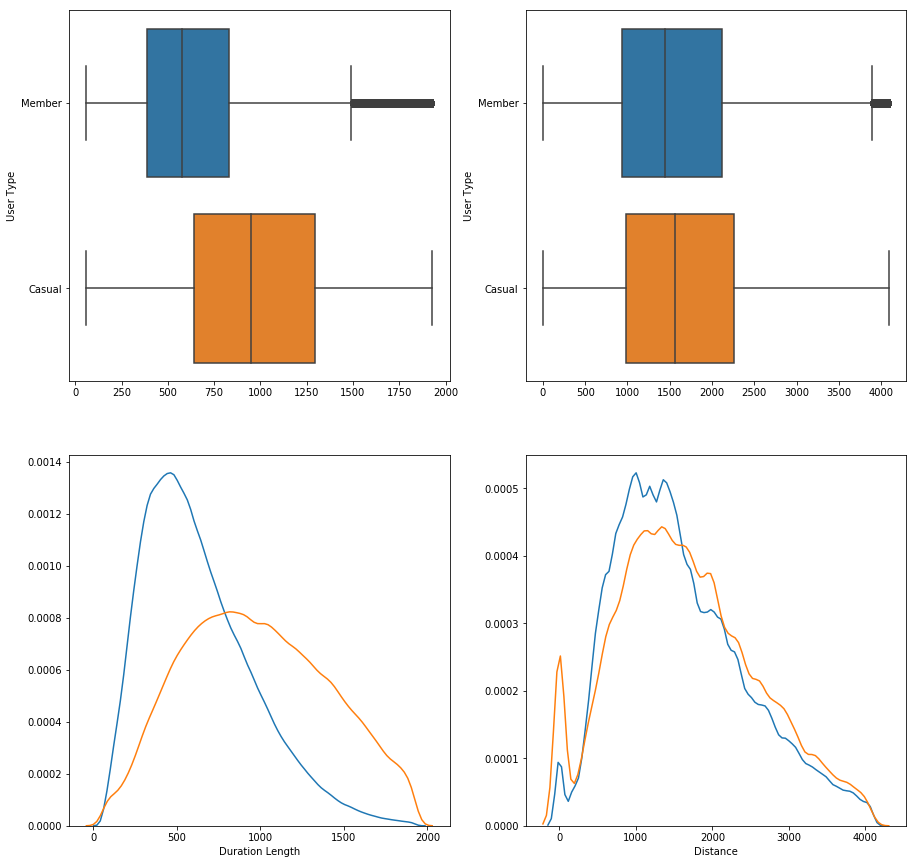

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(15, 15))
for i, col in enumerate(['Duration Length', 'Distance']):
    # Graph the distribution plots (seaborn doesn't allow default separation for distplot)
    for j, user in enumerate(df['User Type'].unique()):
        sns.distplot(df[df['User Type']==user][col], hist=False, ax=ax2[i])
    
    # Graph the boxplots
    sns.boxplot(x=col, y='User Type', data=df, ax=ax1[i])
    ax1[i].set_xlabel('')


I created four plots in total, two boxplots, and two corresponding line plots. The boxplots show the median, first quartile, and third quartile, while the line plots show the shape of the distribution.

In both duration and distance, casual users tend to have a higher trip length median. In terms of distance, casual users have a median of around 1550, whereas members have a median of around 1450. In terms of duration, casual users have a median of around 900, whereas members have a median of around 550, which differs more than the distance. This can be explained by that members tend to use the bike on a daily basis such as commuting, while casual users prefer to use the bike occasionally such as biking around the city for tourism purposes. In terms of duration, both distributions are unimodal. However, in terms of distance, both distributions are bimodal, having a lower peak at a distance around zero. This might be because people return the bike to the start station after they finish their tasks, for example, the stations beside TTC stations can explain the phenomenon.

## How Weather Affects Trip Length

To compare how mean temperature, total rain, and total snow affect the trip length, I first divide the mean temperate, total rain and total snow into different range groups so that we can compare the trip lengths group by group. Next, I created boxplots of each of the weather factors and each of the trip length definitions.

In [29]:
mean_temp = new_df[['Duration Length', 'Distance', 'Mean Temp']]
mean_temp = mean_temp.dropna()



In [30]:
mean_temp['Mean Temp'] = mean_temp['Mean Temp'].astype(float)

In [31]:
mean_temp.loc[(mean_temp['Mean Temp'] >= -20) & (mean_temp['Mean Temp'] < -15), 'Temp Group'] = '-20~-15'
mean_temp.loc[(mean_temp['Mean Temp'] >= -15) & (mean_temp['Mean Temp'] < -10), 'Temp Group'] = '-15~-10'
mean_temp.loc[(mean_temp['Mean Temp'] >= -10) & (mean_temp['Mean Temp'] < -5), 'Temp Group'] = '-10~-5'
mean_temp.loc[(mean_temp['Mean Temp'] >= -5) & (mean_temp['Mean Temp'] < 0), 'Temp Group'] = '-5~0'
mean_temp.loc[(mean_temp['Mean Temp'] >= 0) & (mean_temp['Mean Temp'] < 5), 'Temp Group'] = '0~5'
mean_temp.loc[(mean_temp['Mean Temp'] >= 5) & (mean_temp['Mean Temp'] < 10), 'Temp Group'] = '5~10'
mean_temp.loc[(mean_temp['Mean Temp'] >= 10) & (mean_temp['Mean Temp'] < 15), 'Temp Group'] = '10~15'
mean_temp.loc[(mean_temp['Mean Temp'] >= 15) & (mean_temp['Mean Temp'] < 20), 'Temp Group'] = '15~20'
mean_temp.loc[(mean_temp['Mean Temp'] >= 20) & (mean_temp['Mean Temp'] < 25), 'Temp Group'] = '20~25'
mean_temp.loc[(mean_temp['Mean Temp'] >= 25) & (mean_temp['Mean Temp'] < 30), 'Temp Group'] = '25~30'
mean_temp.loc[(mean_temp['Mean Temp'] >= 30) & (mean_temp['Mean Temp'] < 35), 'Temp Group'] = '30~35'


Text(0.5, 1.0, 'Box Plot of Mean Temp and Distance')

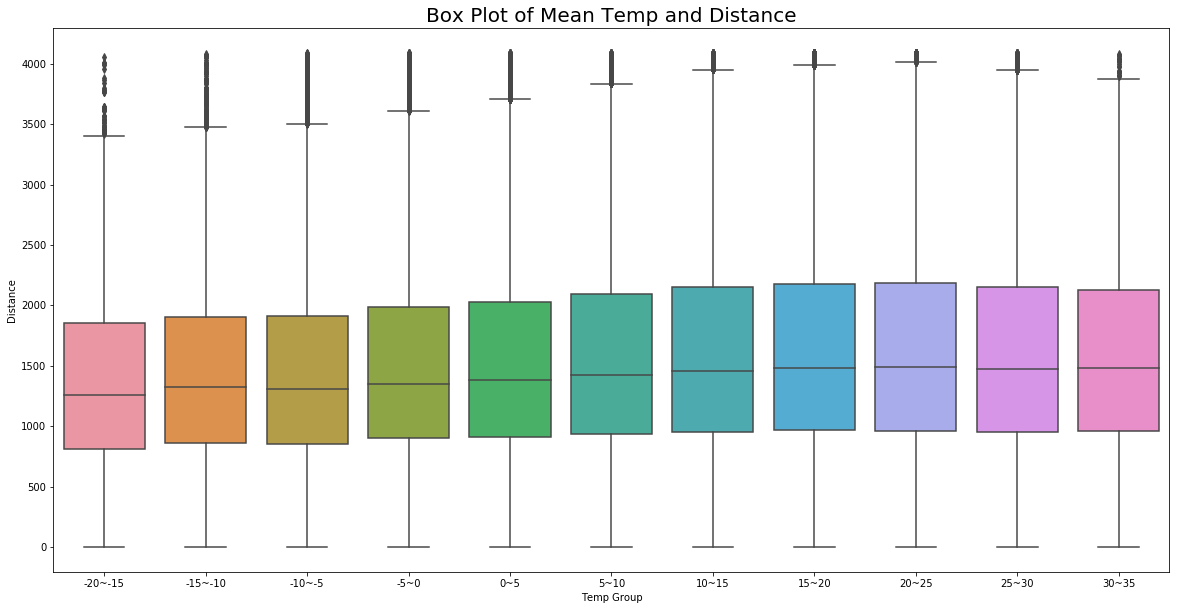

In [34]:
plt.figure(figsize=(20,10))
order = ['-20~-15', '-15~-10', '-10~-5', '-5~0', '0~5', '5~10', '10~15', '15~20', '20~25', '25~30', '30~35']
sns.boxplot(x = 'Temp Group' , y = 'Distance', data = mean_temp, order=order)
plt.title('Box Plot of Mean Temp and Distance', fontsize=20)

The mean temperature has little effect on distance. As shown in the plot, the distance median of each temperature group only variates a little. The highest is in the 20~25 degree group and the lowest is in the -20 ~ -15 degree group. However, there is still an increasing trend of distance as temperature increases, and after the temperature reaches 20 to 25 degrees, the distance starts to decrease a little.

Text(0.5, 1.0, 'Box Plot of Mean Temp and Duration')

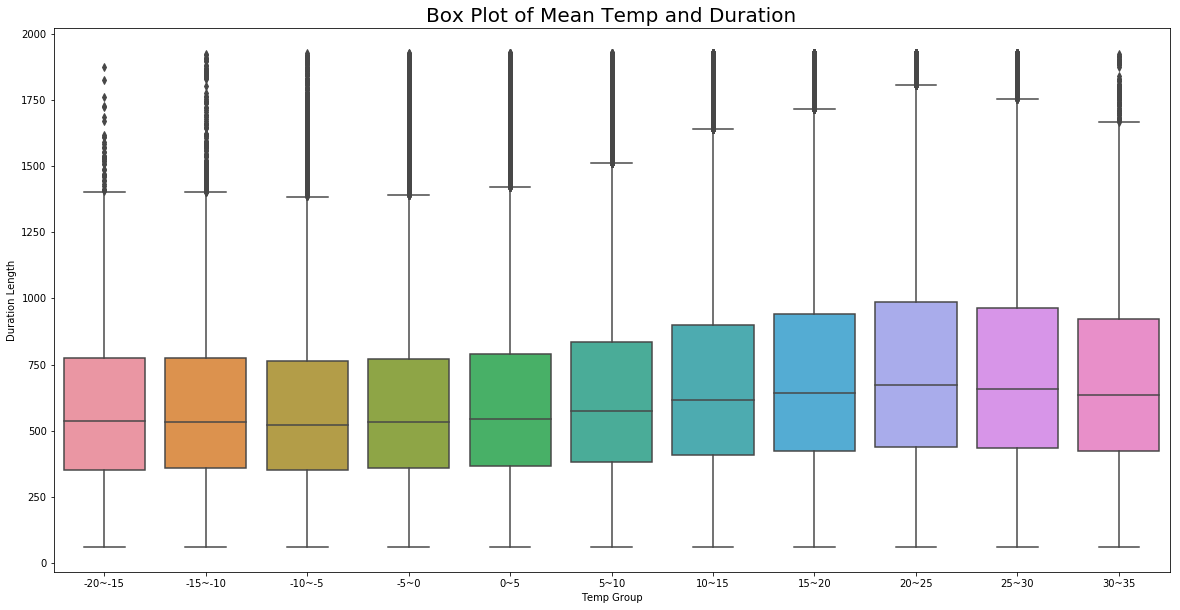

In [35]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'Temp Group' , y = 'Duration Length', data = mean_temp, order=order)
plt.title('Box Plot of Mean Temp and Duration', fontsize=20)

Such increasing trend is more obvious in terms of duration, and it also reaches its peak in the 20~25 degree group. But the difference between the highest group and the lowest group is larger compared to the distance. Overall, both distance and duration have the same trend as temperature changes, and temperature plays a role in trip distance and duration.

In [36]:
pd.set_option('display.max_columns', None)
mean_temp.groupby(['Temp Group']).describe()

Duration Length                                               \
                     count        mean         std   min     25%    50%   
Temp Group                                                                
-10~-5             33840.0  588.590662  319.794441  60.0  349.75  523.0   
-15~-10             7699.0  596.554747  319.312394  60.0  359.00  533.0   
-20~-15             1597.0  597.445836  323.806802  60.0  352.00  536.0   
-5~0               64091.0  596.985786  318.427261  60.0  360.00  534.0   
0~5               147510.0  606.754173  322.000711  60.0  365.00  543.0   
10~15             215397.0  684.492050  366.522455  60.0  407.00  615.0   
15~20             437445.0  713.171695  376.685616  60.0  425.00  644.0   
20~25             583909.0  742.928958  391.053913  60.0  440.00  673.0   
25~30             137824.0  730.021375  386.100598  60.0  434.00  658.0   
30~35               4270.0  711.989696  375.522613  62.0  424.00  636.0   
5~10              167364.0  638.491976  339.948458  60.0  383.00  573.0   

                            Distance                                \
               75%     max     count         mean         std  min   
Temp Group                                                           
-10~-5      764.00  1927.0   33840.0  1452.314973  799.701501  0.0   
-15~-10     776.00  1922.0    7699.0  1454.238557  794.178656  0.0   
-20~-15     773.00  1876.0    1597.0  1408.544118  802.941202  0.0   
-5~0        772.00  1927.0   64091.0  1500.843522  812.835536  0.0   
0~5         788.00  1928.0  147510.0  1535.109209  831.789746  0.0   
10~15       900.00  1928.0  215397.0  1605.438207  868.972434  0.0   
15~20       941.00  1928.0  437445.0  1623.426038  875.396242  0.0   
20~25       986.00  1928.0  583909.0  1623.904709  880.219106  0.0   
25~30       962.00  1928.0  137824.0  1599.043561  865.983347  0.0   
30~35       920.75  1922.0    4270.0  1600.366049  844.468583  0.0   
5~10        834.00  1928.0  167364.0  1572.112847  845.685678  0.0   

                                                              Mean Temp  \
                   25%          50%          75%          max     count   
Temp Group                                                                
-10~-5      856.765785  1312.064247  1915.595969  4090.145962   33840.0   
-15~-10     861.135198  1322.876468  1906.705940  4083.649568    7699.0   
-20~-15     811.507060  1258.655275  1852.539827  4057.612576    1597.0   
-5~0        899.436771  1351.181013  1984.438979  4090.145962   64091.0   
0~5         914.693411  1383.847266  2031.575095  4090.163366  147510.0   
10~15       949.527045  1460.213827  2151.049654  4090.626363  215397.0   
15~20       968.338065  1484.415565  2176.323276  4090.229570  437445.0   
20~25       964.370261  1492.550079  2185.386523  4090.229570  583909.0   
25~30       949.787304  1470.352415  2149.191443  4090.229570  137824.0   
30~35       960.500371  1486.314481  2131.359951  4080.590166    4270.0   
5~10        937.728603  1423.721539  2098.221460  4090.145962  167364.0   

                                                               
                 mean       std   min   25%   50%   75%   max  
Temp Group                                                     
-10~-5      -7.200021  1.329295 -10.0  -8.0  -7.1  -6.1  -5.2  
-15~-10    -11.019860  1.020905 -14.4 -11.1 -10.9 -10.4 -10.1  
-20~-15    -16.985097  1.244704 -18.6 -17.5 -17.5 -15.5 -15.5  
-5~0        -2.390390  1.448688  -5.0  -3.5  -2.1  -1.2  -0.1  
0~5          2.819381  1.388712   0.1   1.9   2.8   3.9   4.9  
10~15       12.836743  1.399808  10.1  11.5  13.2  14.0  14.9  
15~20       17.522190  1.414630  15.0  16.2  17.4  18.9  19.9  
20~25       22.342720  1.281862  20.0  21.4  22.2  23.4  24.7  
25~30       26.420432  1.122647  25.2  25.6  26.1  26.6  29.0  
30~35       30.500000  0.000000  30.5  30.5  30.5  30.5  30.5  
5~10         7.078969  1.285010   5.0   5.9   6.9   8.0   9.5

In [39]:
total_rain = new_df[['Duration Length', 'Distance', 'Total Rain']]
total_rain = total_rain.dropna()
total_rain['Total Rain'] = total_rain['Total Rain'].astype(float)
total_rain.loc[(total_rain['Total Rain'] >= 0) & (total_rain['Total Rain'] < 10), 'Rain Group'] = '0~10'
total_rain.loc[(total_rain['Total Rain'] >= 10) & (total_rain['Total Rain'] < 20), 'Rain Group'] = '10~20'
total_rain.loc[(total_rain['Total Rain'] >= 20) & (total_rain['Total Rain'] < 30), 'Rain Group'] = '20~30'
total_rain.loc[(total_rain['Total Rain'] >= 30) & (total_rain['Total Rain'] < 40), 'Rain Group'] = '30~40'
total_rain.loc[(total_rain['Total Rain'] >= 40), 'Rain Group'] = '40+'

Text(0.5, 1.0, 'Box Plot of Total Rain and Distance')

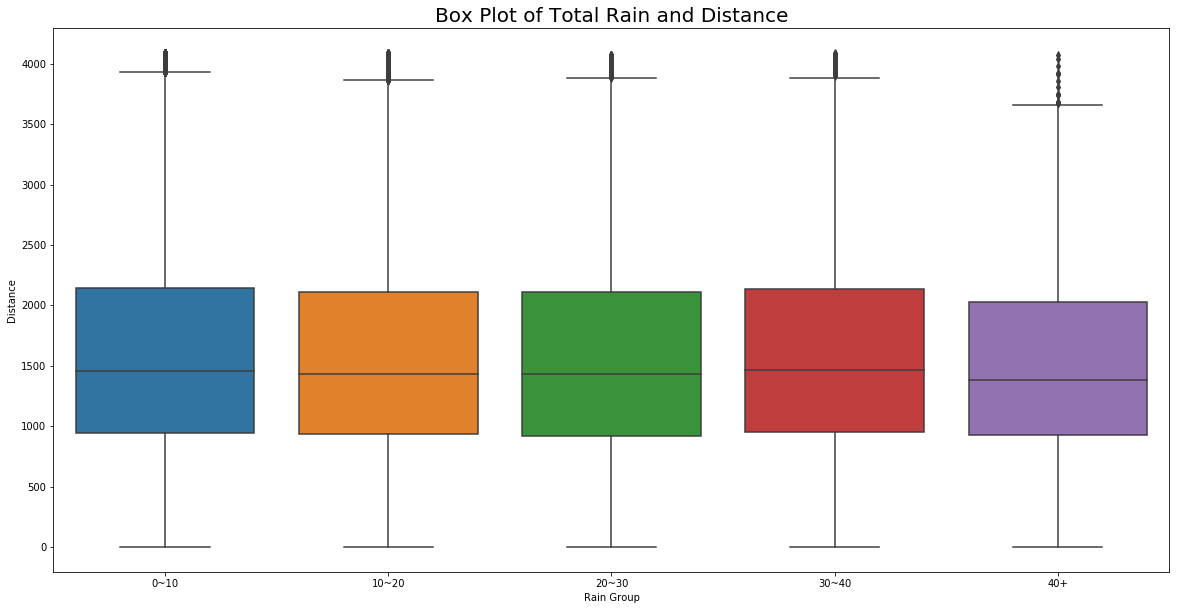

In [40]:
plt.figure(figsize=(20,10))
order2 = ['0~10', '10~20', '20~30', '30~40', '40+']
sns.boxplot(x = 'Rain Group' , y = 'Distance', data = total_rain, order=order2)
plt.title('Box Plot of Total Rain and Distance', fontsize=20)

Text(0.5, 1.0, 'Box Plot of Total Rain and Duration')

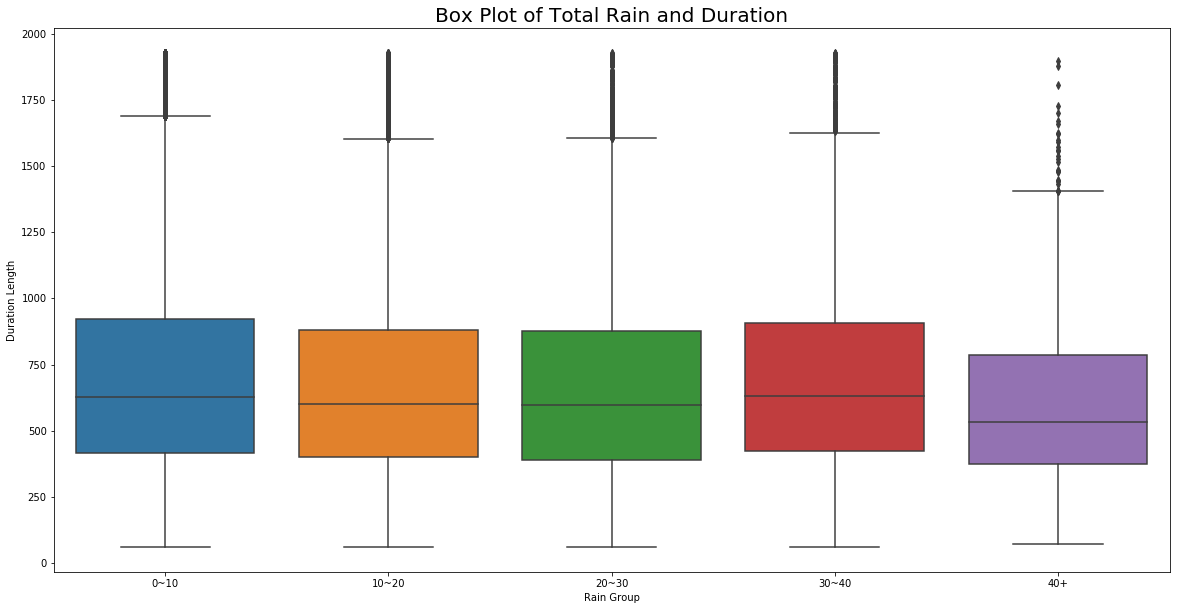

In [41]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'Rain Group' , y = 'Duration Length', data = total_rain, order=order2)
plt.title('Box Plot of Total Rain and Duration', fontsize=20)

The trip distance and duration do not variate a lot when total rain changes. As shown in the graph, all four rain groups have very similar median, first quartile and third quartile. Their IQR are very similar to each other as well. Except for total rain is greater than 40, both trip distance and trip duration decrease. However, this result might be biased because we only have a few raining days in a year.

In [42]:
total_rain.groupby(['Rain Group']).describe()

Duration Length                                                     \
                     count        mean         std   min    25%    50%    75%   
Rain Group                                                                      
0~10             1543244.0  700.635963  375.399323  60.0  414.0  628.0  924.0   
10~20              64608.0  668.771406  355.630027  60.0  399.0  600.0  881.0   
20~30              12730.0  666.489002  362.290229  60.0  391.0  597.5  877.0   
30~40               8673.0  697.267612  360.796188  61.0  424.0  632.0  906.0   
40+                 1355.0  603.665683  316.754707  71.0  375.0  534.0  787.0   

                     Distance                                            \
               max      count         mean         std  min         25%   
Rain Group                                                                
0~10        1928.0  1543244.0  1598.825846  867.256753  0.0  946.620463   
10~20       1928.0    64608.0  1573.739149  853.615688  0.0  937.614250   
20~30       1928.0    12730.0  1560.547093  860.022139  0.0  922.612701   
30~40       1928.0     8673.0  1601.718628  861.057943  0.0  953.009935   
40+         1897.0     1355.0  1532.272467  811.836277  0.0  929.238841   

                                                  Total Rain             \
                    50%          75%          max      count       mean   
Rain Group                                                                
0~10        1460.192170  2140.463363  4090.229570  1543244.0   0.889355   
10~20       1434.777257  2108.183196  4090.229570    64608.0  13.838224   
20~30       1431.258523  2107.429282  4077.007770    12730.0  26.400770   
30~40       1465.568649  2132.222826  4089.070406     8673.0  34.416695   
40+         1383.894173  2025.399578  4073.346736     1355.0  44.600000   

                                                        
                     std   min   25%   50%   75%   max  
Rain Group                                              
0~10        1.902185e+00   0.0   0.0   0.0   0.6   9.2  
10~20       3.015285e+00  10.0  11.8  12.6  14.6  19.8  
20~30       3.503753e+00  20.2  25.0  28.0  29.6  29.6  
30~40       1.698056e+00  32.8  32.8  32.8  36.2  36.2  
40+         7.108051e-15  44.6  44.6  44.6  44.6  44.6

In [43]:
total_snow = new_df[['Duration Length', 'Distance', 'Total Snow']]
total_snow = total_snow.dropna()
total_snow['Total Snow'] = total_snow['Total Snow'].astype(float)
total_snow.loc[(total_snow['Total Snow'] >= 0) & (total_snow['Total Snow'] < 5), 'Snow Group'] = '0~5'
total_snow.loc[(total_snow['Total Snow'] >= 5) & (total_snow['Total Snow'] < 10), 'Snow Group'] = '5~10'
total_snow.loc[(total_snow['Total Snow'] >= 10) & (total_snow['Total Snow'] < 15), 'Snow Group'] = '10~15'
total_snow.loc[(total_snow['Total Snow'] >= 15), 'Snow Group'] = '15+'

Text(0.5, 1.0, 'Box Plot of Total Snow and Distance')

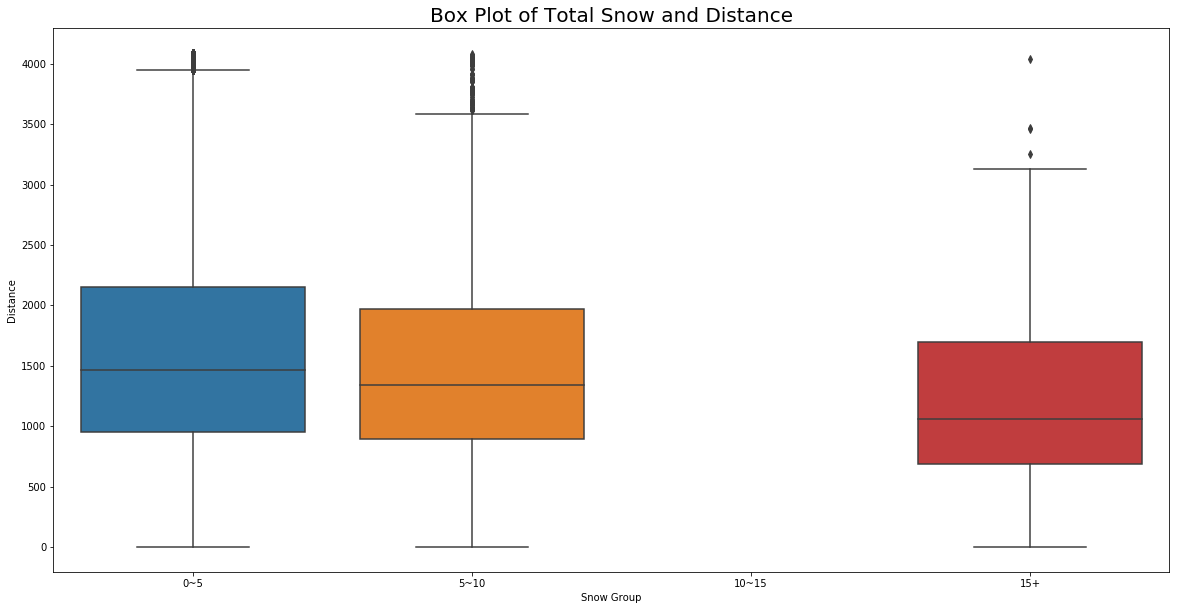

In [44]:
plt.figure(figsize=(20,10))
order3 = ['0~5', '5~10', '10~15', '15+']
sns.boxplot(x = 'Snow Group' , y = 'Distance', data = total_snow, order=order3)
plt.title('Box Plot of Total Snow and Distance', fontsize=20)

Text(0.5, 1.0, 'Box Plot of Total Snow and Duration')

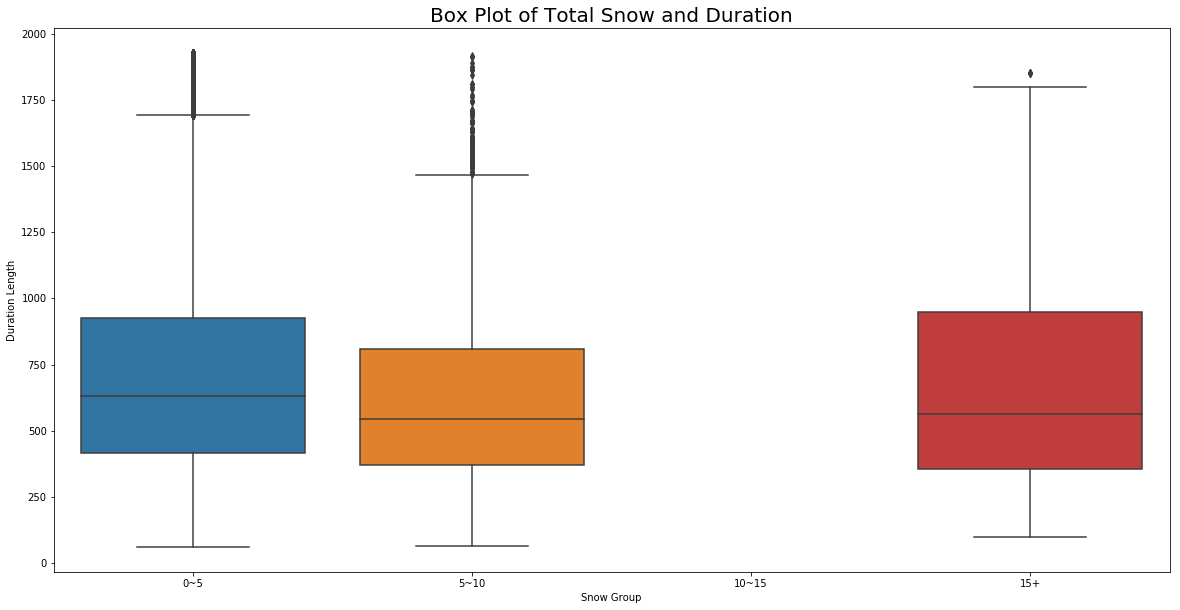

In [45]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'Snow Group' , y = 'Duration Length', data = total_snow, order=order3)
plt.title('Box Plot of Total Snow and Duration', fontsize=20)

In [46]:
total_snow.groupby(['Snow Group']).describe()

Duration Length                                               \
                     count        mean         std   min     25%    50%   
Snow Group                                                                
0~5              1724917.0  702.831068  375.414581  60.0  416.00  631.0   
15+                  242.0  695.202479  430.791740  99.0  356.25  561.5   
5~10                4891.0  622.596810  333.343131  66.0  371.00  545.0   

                            Distance                                \
              75%     max      count         mean         std  min   
Snow Group                                                           
0~5         927.0  1928.0  1724917.0  1603.586167  868.192353  0.0   
15+         950.0  1853.0      242.0  1280.574324  804.102923  0.0   
5~10        810.0  1917.0     4891.0  1501.927045  820.370603  0.0   

                                                              Total Snow  \
                   25%          50%          75%          max      count   
Snow Group                                                                 
0~5         949.797229  1465.912468  2149.806779  4090.626363  1724917.0   
15+         685.666130  1062.941628  1699.584815  4036.174697      242.0   
5~10        894.015697  1340.491692  1974.845203  4085.546030     4891.0   

                                                                   
                 mean           std   min   25%   50%   75%   max  
Snow Group                                                         
0~5          0.027467  2.619429e-01   0.0   0.0   0.0   0.0   4.5  
15+         15.600000  3.560077e-15  15.6  15.6  15.6  15.6  15.6  
5~10         6.076631  9.865101e-01   5.6   5.6   5.6   5.6   8.8

Instead, snow does affect people's bike using behaviour more significantly. As shown in the plot, as total snow increases, both distance and duration median decrease a lot compared to little to no snow. However, Toronto is not the city to ride a bike during snow and I expect the median to be even lower.

## Conclusion

As we discuss above, trip length can be defined in two different ways and they are positively linearly related to each other. When we compare both definitions to other variables, the relationship among them are very similar as well.

Members and causual users have different biking behaviours. Members tend to take shorter trips whereas casual users tend to take longer trips.

Weather does affect how people use the bikes, but not as much as I expected. Out of all three weather factors, snow is the biggest obstacle to prevent people from using the bike and having a shorter trip.

However, the results between how weather affects the trip length might be biased. During extreme weather, some people might just stop using the bikes and choose another way of transportaion. For those who continue use the bikes, they might already be prepared for the circumstance. Thus, I think the weather should affect the number of trips more.